# Global Map of EBC's
Creating a global projection of important mean-state variables: SLP, surface wind stress, SSTs, and placing boxes over the regions that are being investigated. This gives the reader/viewer an idea of where we are working and why these systems are important.

In [50]:
import glob
import numpy as np
import pandas as pd
import xarray as xr
import cmocean
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import esmtools as et

# Create NetCDFs of Ensemble Means
- Storing the global surface ensemble means away as NetCDFs to make processing faster. I don't want to do this with the EBUS_extraction scripts, since we are trying to get a global perspective.
- Historical means, i.e. 1920-2015

# Ocean Output

In [2]:
VAR = 'TAUY'

In [3]:
fileDir = '/glade/scratch/rbrady/EBUS_BGC_Variability/' + VAR + '_monthly/'
ds = xr.open_mfdataset(fileDir + 'reduced*.nc', decode_times=False, concat_dim='ensemble')

OSError: no files to open

In [ ]:
pandaTimes = pd.date_range('1920-01', '2101-01', freq='M')
ds.coords['time'] = pandaTimes
ds.attrs = {}

In [ ]:
#ds = ds.sel(time=slice('1920-1', '2015-12'))

# For landschuetzer time period
ds = ds.sel(time=slice('1982-01', '2011-12'))

In [ ]:
da = ds[VAR].mean(dim='ensemble').mean(dim='time')
da = da.squeeze()

In [ ]:
ds_out = da.to_dataset()
if VAR == 'TAUX' or VAR == 'TAUY':
    ds_out['ANGLE'] = ds['ANGLE'][0]
else:
    ds_out.coords['TLAT'] = ds['TLAT'][0]
    ds_out.coords['TLONG'] = ds['TLONG'][0]

In [ ]:
outDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/global_fields/'
ds_out.to_netcdf(outDir + VAR + '-ensemble-landschuetzer-mean-global.nc')

In [ ]:
inDir ='/glade/p/work/rbrady/EBUS_BGC_Variability/global_fields/'
filename = 'SST-ensemble-historical-mean-global.nc'
ds = xr.open_dataset(inDir + filename)

# Atmosphere Output

In [ ]:
VAR = 'PSL'

In [ ]:
fileDir = '/glade/scratch/rbrady/EBUS_BGC_Variability/' + VAR + '_monthly/'
ds = xr.open_mfdataset(fileDir + 'reduced*.nc', concat_dim='ensemble')

In [ ]:
ds = ds.drop('nbnd')

In [ ]:
ds.attrs = {}

In [ ]:
ds = ds.sel(time=slice('1920-01', '2015-12'))

In [ ]:
ds = ds['PSL'].mean(dim='ensemble').mean(dim='time')

In [ ]:
ds = ds/100

In [ ]:
ds = ds.squeeze()

In [ ]:
LON,LAT = np.meshgrid(ds.lon.values, ds.lat.values)

In [ ]:
ds.coords['LON'] = (('lat','lon'), LON)
ds.coords['LAT'] = (('lat','lon'), LAT)

In [ ]:
ds = ds.to_dataset()

In [ ]:
outDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/global_fields/'
ds.to_netcdf(outDir + VAR + '-ensemble-historical-mean-global.nc')

# Visualization Functions

In [32]:
def setup_map(ax):
    m = Basemap(projection='robin',
                lon_0=0,
               resolution='c')
    #m.drawcoastlines()
    m.fillcontinents(color='k')
    m.drawparallels(np.arange(-90,120.,15.))
    m.drawmeridians(np.arange(0.,360.,60.))
    m.drawcoastlines(color='k')
    #m.drawcountries()
    #m.fillcontinents(color='#D3D3D3')
    m.drawmapboundary(fill_color='white')
    return m

In [33]:
def load_global_field(VAR):
    inDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/global_fields/'
    fileName = VAR + '-ensemble-historical-mean-global.nc'
    ds = xr.open_dataset(inDir + fileName)
    return ds

In [34]:
def visual_bounds(EBU):
    if EBU == "CalCS":
        lat1 = 25
        lat2 = 43
        lon1 = -133+360
        lon2 = -110+360
    elif EBU == 'HumCS':
        lat1 = -20
        lat2 = -2
        lon1 = -90
        lon2 = -70
    elif EBU == 'CanCS':
        lat1 = 10
        lat2 = 28
        lon1 = -25
        lon2 = -10
    elif EBU == 'BenCS':
        lat1 = -35
        lat2 = -15
        lon1 = 5
        lon2 = 20
    return lat1,lat2,lon1,lon2

In [35]:
def find_indices(latGrid, lonGrid, latPoint, lonPoint):
    dx = lonGrid - lonPoint
    dy = latGrid - latPoint
    reducedGrid = abs(dx) + abs(dy)
    min_ix = np.nanargmin(reducedGrid)
    i, j = np.unravel_index(min_ix, reducedGrid.shape)
    return i, j

In [36]:
from matplotlib.patches import Polygon
def draw_screen_poly(lats, lons, m):
    x, y = m(lons, lats)
    xy = zip(x,y)
    poly = Polygon( xy, edgecolor='w', facecolor='none', linewidth=2 )
    plt.gca().add_patch(poly)

# Visualization Code

In [37]:
# Load in data
ds_sst = load_global_field('SST')
ds_psl = load_global_field('PSL')
ds_taux = load_global_field('TAUX')
ds_tauy = load_global_field('TAUY')

# Set up coordinates
alat = ds_psl['LAT'].values
along = ds_psl['LON'].values
tlong = ds_sst['TLONG'].values
tlat = ds_sst['TLAT'].values
ulong = ds_taux['ULONG'].values
ulat = ds_taux['ULAT'].values
angle = ds_taux['ANGLE'].values

# Set up data
sst = ds_sst['SST'].values
psl = ds_psl['PSL'].values
taux = ds_taux['TAUX'].values
tauy = ds_tauy['TAUY'].values

# Rotate winds for flat projection.
u = taux*np.cos(angle) - tauy*np.sin(angle) 
v = taux*np.sin(angle) + tauy*np.cos(angle) 

In [38]:
# Drop winds in the Southern Ocean
mask = ( ulat < -50 )
u2 = u.copy()
v2 = v.copy()
u2[mask] = np.nan
v2[mask] = np.nan

In [39]:
# Convert to N/m2
u2 = u2 * 100 * 100 / 10**5
v2 = v2 * 100 * 100 / 10**5

In [100]:
new_lon,new_lat,new_data = et.vis.deseam(along,alat,psl)

# Drop winds in the Southern Ocean
mask = ( new_lat < -50 )
new_data2 = new_data.copy()
new_data2[mask] = np.nan

In [112]:
help(et.vis.savefig)

Help on function savefig in module esmtools.vis:

savefig(filename, directory=None, extension='.png', transparent=True, dpi=300)
    Save a publication-ready figure.
    
    Parameters
    ----------
    filename : str
        The name of the file (without the extension)
    directory : str (optional)
        Identify a directory to place the file. Otherwise it will be placed locally.
    extension : str (optional)
        Identify a filetype. Defaults to .png
    transparent : boolean (optional)
        Whether or not to save with a transparent background. Default is True.
    dpi : int (optional)
        Dots per inch, or resolution. Defaults to 300.
    
    Returns
    -------
    A saved file.



/glade/u/home/rbrady/anaconda3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1711: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/glade/u/home/rbrady/anaconda3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1711: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


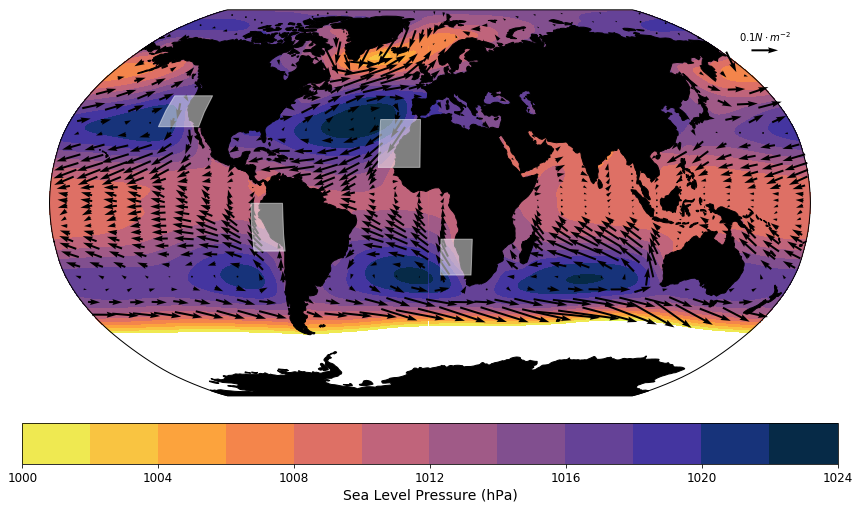

In [113]:
f, ax = et.vis.make_cartopy(figsize=(15,15), grid_lines=False)

#Pressure 
p = ax.pcolormesh(new_lon,new_lat,new_data2,transform=ccrs.PlateCarree(),vmin=1000,vmax=1026,
              cmap=cmocean.cm.thermal_r)
c = ax.contourf(along,alat,psl,np.arange(1000,1026,2),transform=ccrs.PlateCarree(),
            cmap=cmocean.cm.thermal_r)
cb = plt.colorbar(c, orientation='horizontal', pad=0.01, fraction=0.05)
cb.set_label('Sea Level Pressure (hPa)', fontsize=14)
cb.ax.tick_params(labelsize=12)

# Winds
num = 10
Q = ax.quiver(ulong[::num,::num], ulat[::num,::num], u2[::num,::num], v2[::num,::num], 
             transform=ccrs.PlateCarree(), scale_units='width', pivot='mid')
qk = plt.quiverkey(Q, 0.9, 0.9, 0.1, r'$0.1 N\cdot m^{-2}$', labelpos='N',
                   coordinates='axes')

# Add boxes for EBU's
EBUS = ['CalCS', 'HumCS', 'CanCS', 'BenCS']
for idx in EBUS:
    x0,x1,y0,y1 = et.ebus.visual_bounds(idx, std_lon=True)
    et.vis.add_box(ax,x0,x1,y0,y1,edgecolor='w',facecolor='w',alpha=0.5)
    
# Save figure
et.vis.savefig('global_EBUS_map', extension='.eps')